[Reference](https://medium.com/bitgrit-data-science-publication/fast-exploratory-data-analysis-with-one-line-of-code-677fcba2342e)

In [18]:
# import iris dataset from sklearn
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd

housing = fetch_openml(name="house_prices", as_frame=True)

# create a dataframe
df = housing.frame

# select 3 categorical and 3 numerical columns
df = df[['MSZoning', 'LotArea', 'GrLivArea', 'Street', 'Neighborhood', 'OverallQual', 'SalePrice']]

# randomly impute with null values except for SalePrice column
df = df.apply(lambda x: np.where(np.random.random(len(x)) < 0.1, np.nan, x) if x.name != 'SalePrice' else x)

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [19]:
df.head()

,MSZoning,LotArea,GrLivArea,Street,Neighborhood,OverallQual,SalePrice
0,RL,8450.0,1710.0,Pave,CollgCr,7.0,208500
1,RL,9600.0,NaN,Pave,Veenker,6.0,181500
2,RL,11250.0,1786.0,Pave,NaN,7.0,223500
3,RL,9550.0,1717.0,NaN,Crawfor,7.0,140000
4,RL,14260.0,2198.0,Pave,NoRidge,8.0,250000


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSZoning      1322 non-null   object 
 1   LotArea       1287 non-null   float64
 2   GrLivArea     1305 non-null   float64
 3   Street        1332 non-null   object 
 4   Neighborhood  1308 non-null   object 
 5   OverallQual   1312 non-null   float64
 6   SalePrice     1460 non-null   int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 80.0+ KB


In [21]:
null_cols = [i for i in df.columns if df[i].isna().sum() > 0]
df0 = df[null_cols]
null_cols

['MSZoning', 'LotArea', 'GrLivArea', 'Street', 'Neighborhood', 'OverallQual']

In [22]:
display(
    df0.isna()
    .sum()
    .to_frame()
    .style.set_properties(
        **{
            "background-color": "#000000",
            "color": "#ff0000",
            "font-weight": "bold",
        }
    )
)

,0
MSZoning,138
LotArea,173
GrLivArea,155
Street,128
Neighborhood,152
OverallQual,148


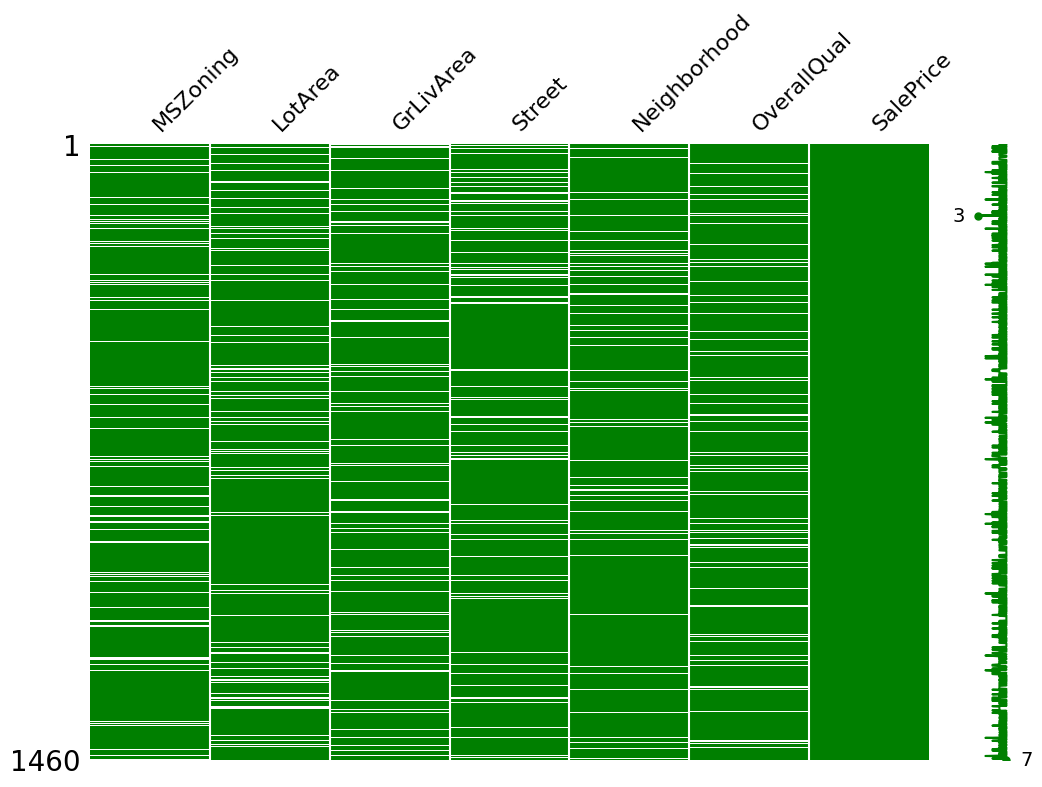

----------------------------------------------------------------------------------------------------


In [23]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df, color=(0, 0.5, 0), figsize=(12, 8))
plt.show()
print("-" * 100)

In [24]:
from scipy.stats import skew, kurtosis

skew_ = (
    df._get_numeric_data().dropna().apply(lambda x: skew(x)).to_frame(name="skewness")
)
kurt_ = (
    df._get_numeric_data()
    .dropna()
    .apply(lambda x: kurtosis(x))
    .to_frame(name="kurtosis")
)
skew_kurt = pd.concat([skew_, kurt_], axis=1)

skew_kurt

,skewness,kurtosis
LotArea,10.580252,153.543754
GrLivArea,1.260521,3.232903
OverallQual,0.332318,0.000371
SalePrice,1.998434,7.515721


In [25]:
desc_df = df.describe().T

desc_df

,count,mean,std,min,25%,50%,75%,max
LotArea,1287.0,10504.902098,8869.847356,1300.0,7520.0,9473.0,11634.0,164660.0
GrLivArea,1305.0,1520.621456,533.382440,334.0,1128.0,1466.0,1786.0,5642.0
OverallQual,1312.0,6.116616,1.371264,2.0,5.0,6.0,7.0,10.0
SalePrice,1460.0,180921.195890,79442.502883,34900.0,129975.0,163000.0,214000.0,755000.0


In [26]:
full_info = pd.concat([desc_df, skew_kurt], ignore_index=True, axis=1)

full_info.columns = list(desc_df.columns) + list(skew_kurt.columns)
full_info.insert(
    loc=2, column="median", value=df.median(skipna=True, numeric_only=True)
)

full_info.iloc[:, :-2] = full_info.iloc[:, :-2].applymap(
    lambda x: format(x, ".3f").rstrip("0").rstrip(".")
    if isinstance(x, (int, float))
    else x
)

full_info

,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
LotArea,1287,10504.902,9473,8869.847,1300,7520,9473,11634,164660,10.580252,153.543754
GrLivArea,1305,1520.621,1466,533.382,334,1128,1466,1786,5642,1.260521,3.232903
OverallQual,1312,6.117,6,1.371,2,5,6,7,10,0.332318,0.000371
SalePrice,1460,180921.196,163000,79442.503,34900,129975,163000,214000,755000,1.998434,7.515721


In [28]:
def color_negative_red(value):
    if value < 0:
        color = "#ff0000"
    elif value > 0:
        color = "#00ff00"
    else:
        color = "#FFFFFF"
    return "color: %s" % color


info_cols = ["skewness", "kurtosis"]

display(
    full_info.style.background_gradient(cmap="Spectral", subset=full_info.columns[:-2])
    .applymap(color_negative_red, subset=info_cols)
    .set_properties(
        **{"background-color": "#000000", "font-weight": "bold"},
        subset=info_cols,
    )
    .set_properties(**{"font-weight": "bold"}, subset=full_info.columns[:-2])
)

,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
LotArea,1287,10504.902,9473,8869.847,1300,7520,9473,11634,164660,10.580252,153.543754
GrLivArea,1305,1520.621,1466,533.382,334,1128,1466,1786,5642,1.260521,3.232903
OverallQual,1312,6.117,6,1.371,2,5,6,7,10,0.332318,0.000371
SalePrice,1460,180921.196,163000,79442.503,34900,129975,163000,214000,755000,1.998434,7.515721


In [29]:
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
 
print(f"{cat_cols=}")

# Catch variables that are numeric but have less than 15 classes 
num_but_cat = [
    col
    for col in df.columns
    if df[col].nunique() <= 15 and df[col].dtypes != "O"
]

print(f"{num_but_cat=}")

cat_cols = cat_cols + num_but_cat
print(f"{cat_cols=}")

# catch variables that are categorical but have an immeasurably large number of classes (>15 in this case)
cat_but_car = [
    col
    for col in df.columns
    if df[col].nunique() > 15 and df[col].dtypes == "O"
]

print(f"{cat_but_car=}")

cat_cols = [col for col in cat_cols if col not in cat_but_car]
print(f"{cat_cols=}")

cat_cols=['MSZoning', 'Street', 'Neighborhood']
num_but_cat=['OverallQual']
cat_cols=['MSZoning', 'Street', 'Neighborhood', 'OverallQual']
cat_but_car=['Neighborhood']
cat_cols=['MSZoning', 'Street', 'OverallQual']


In [30]:
num_cols = [col for col in df.columns if df[col].dtypes != "O"]

# Catch variables that are numeric but have less than 15 classes 
num_but_cat = [
    col
    for col in df.columns
    if df[col].nunique() <= 15 and df[col].dtypes != "O"
]

num_cols = [col for col in num_cols if col not in num_but_cat]
num_cols

['LotArea', 'GrLivArea', 'SalePrice']

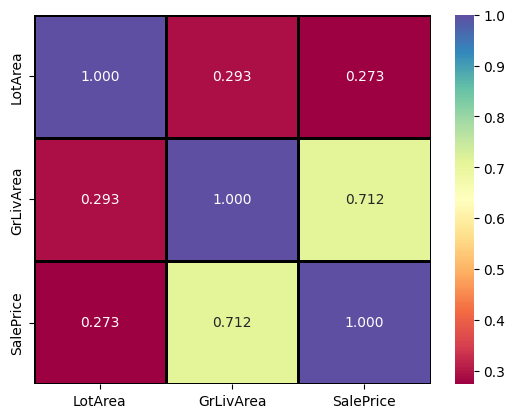

In [31]:
import seaborn as sns
sns.heatmap(
    df[num_cols].corr(),
    annot=True,
    cmap="Spectral",
    linewidths=2,
    linecolor="#000000",
    fmt=".3f",
);

In [33]:
!pip install fasteda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fasteda: filename=fasteda-1.0.1-py3-none-any.whl size=4736 sha256=79548860aa95a8bb6b4ef638fa8eb20e413cf6c0ea17bf4a100214b76448d8da
  Stored in directory: /root/.cache/pip/wheels/93/57/7e/fdc4b9923cf3f1f46de4e2ea7a5a4acb335357f919920ffb7c
Successfully built fasteda


DataFrame Head:


,MSZoning,LotArea,GrLivArea,Street,Neighborhood,OverallQual,SalePrice
0,RL,8450.0,1710.0,Pave,CollgCr,7.0,208500
1,RL,9600.0,NaN,Pave,Veenker,6.0,181500
2,RL,11250.0,1786.0,Pave,NaN,7.0,223500


DataFrame Tail:


,MSZoning,LotArea,GrLivArea,Street,Neighborhood,OverallQual,SalePrice
1457,RL,9042.0,2340.0,Pave,Crawfor,7.0,266500
1458,NaN,9717.0,1078.0,Pave,NAmes,5.0,142125
1459,RL,9937.0,1256.0,Pave,Edwards,5.0,147500


----------------------------------------------------------------------------------------------------
Missing values:


,0
MSZoning,138
LotArea,173
GrLivArea,155
Street,128
Neighborhood,152
OverallQual,148


----------------------------------------------------------------------------------------------------
MSNO Matrix:



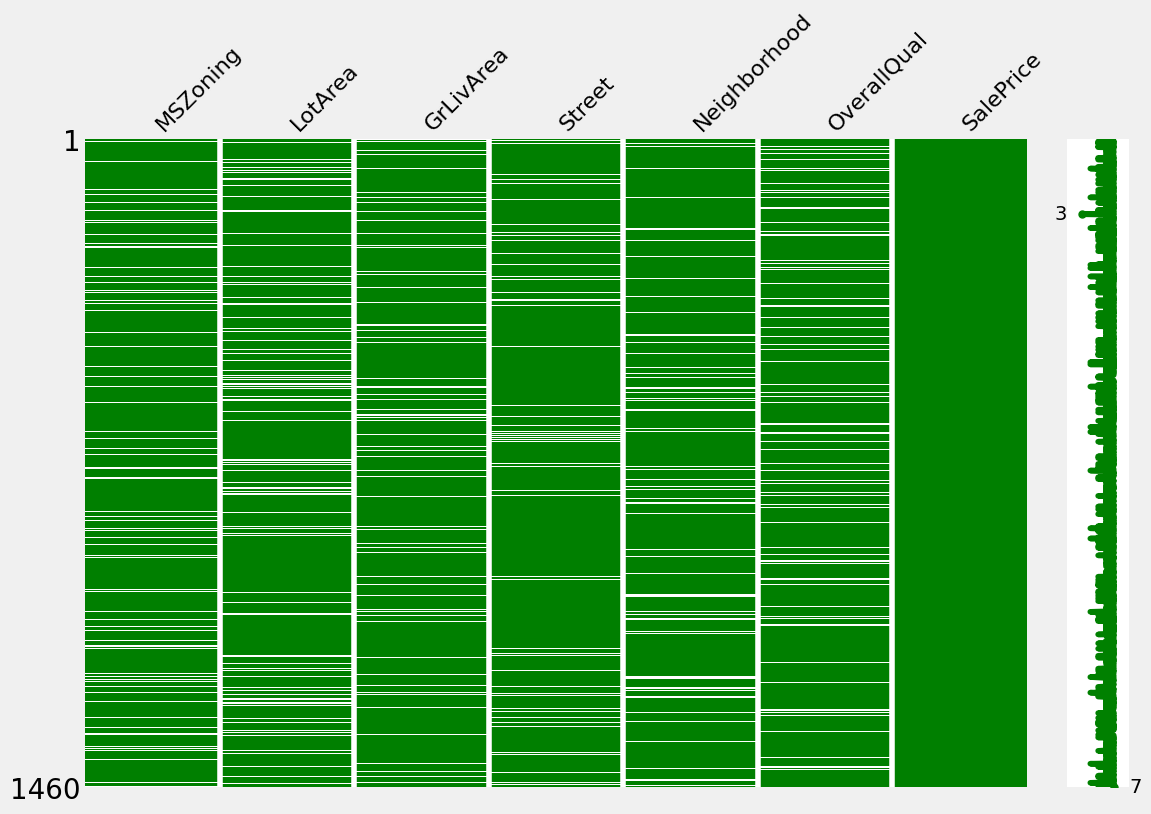

----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(1460, 7)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSZoning      1322 non-null   object 
 1   LotArea       1287 non-null   float64
 2   GrLivArea     1305 non-null   float64
 3   Street        1332 non-null   object 
 4   Neighborhood  1308 non-null   object 
 5   OverallQual   1312 non-null   float64
 6   SalePrice     1460 non-null   int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 80.0+ KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
LotArea,1287,10504.902,9473,8869.847,1300,7520,9473,11634,164660,10.580252,153.543754
GrLivArea,1305,1520.621,1466,533.382,334,1128,1466,1786,5642,1.260521,3.232903
OverallQual,1312,6.117,6,1.371,2,5,6,7,10,0.332318,0.000371
SalePrice,1460,180921.196,163000,79442.503,34900,129975,163000,214000,755000,1.998434,7.515721


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



/usr/local/lib/python3.9/dist-packages/fasteda/__init__.py:124: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True, cmap = "Spectral", linewidths = 2, linecolor = "#000000", fmt='.3f')


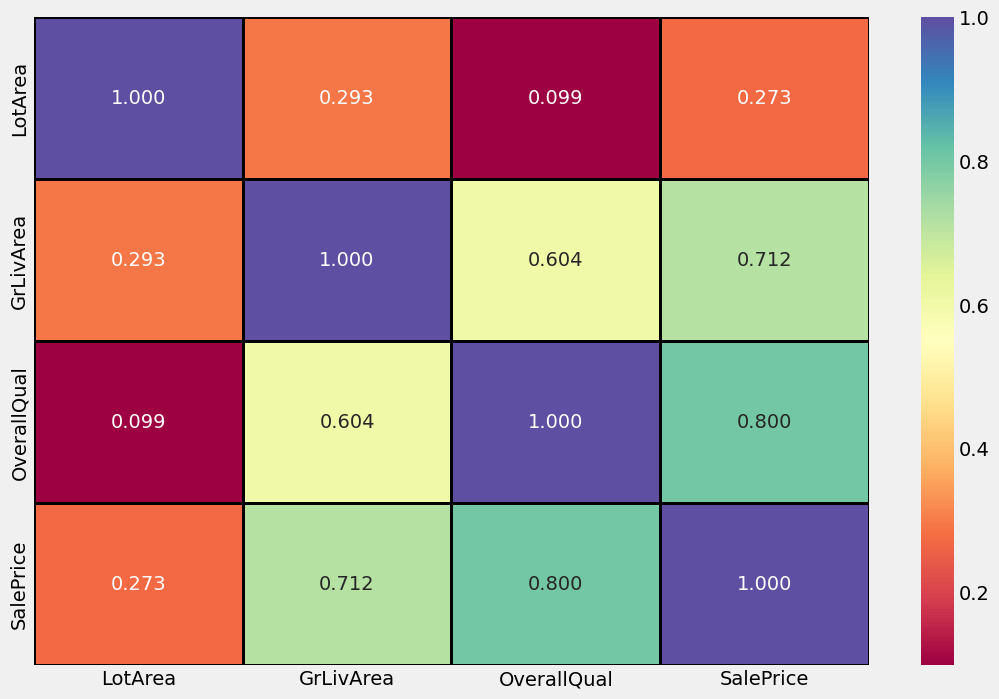

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



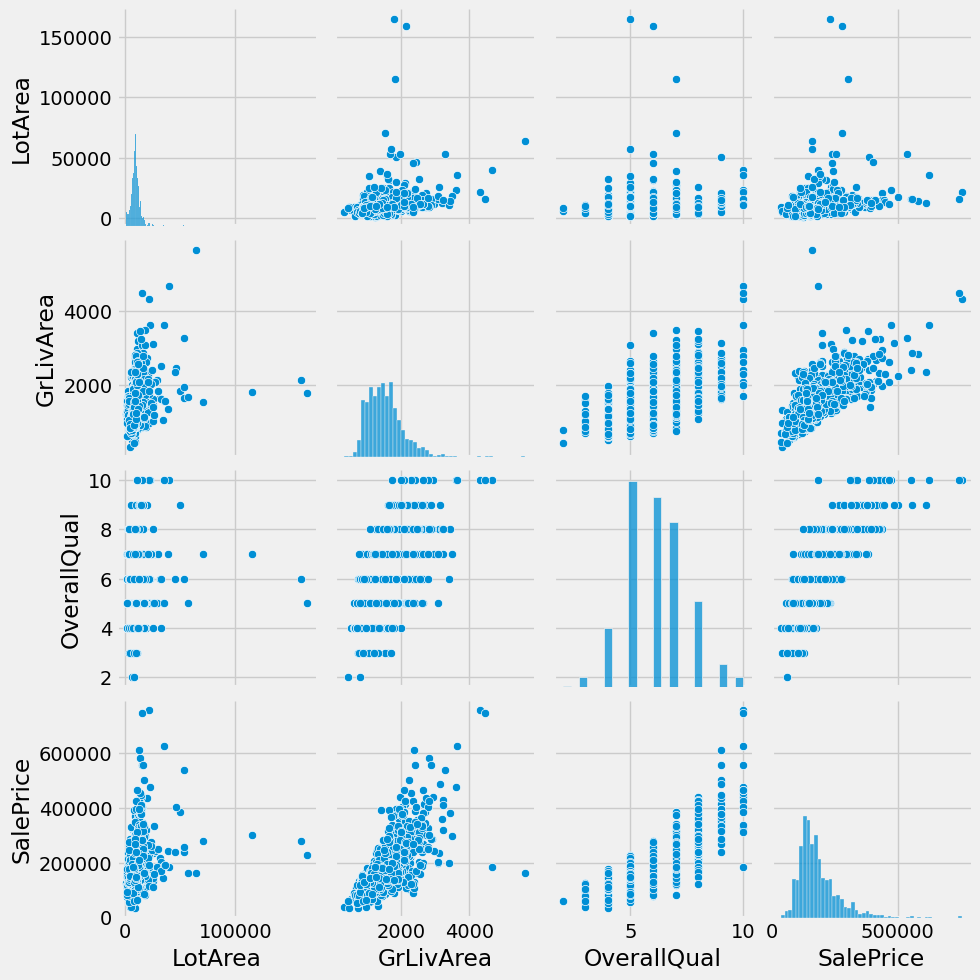

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



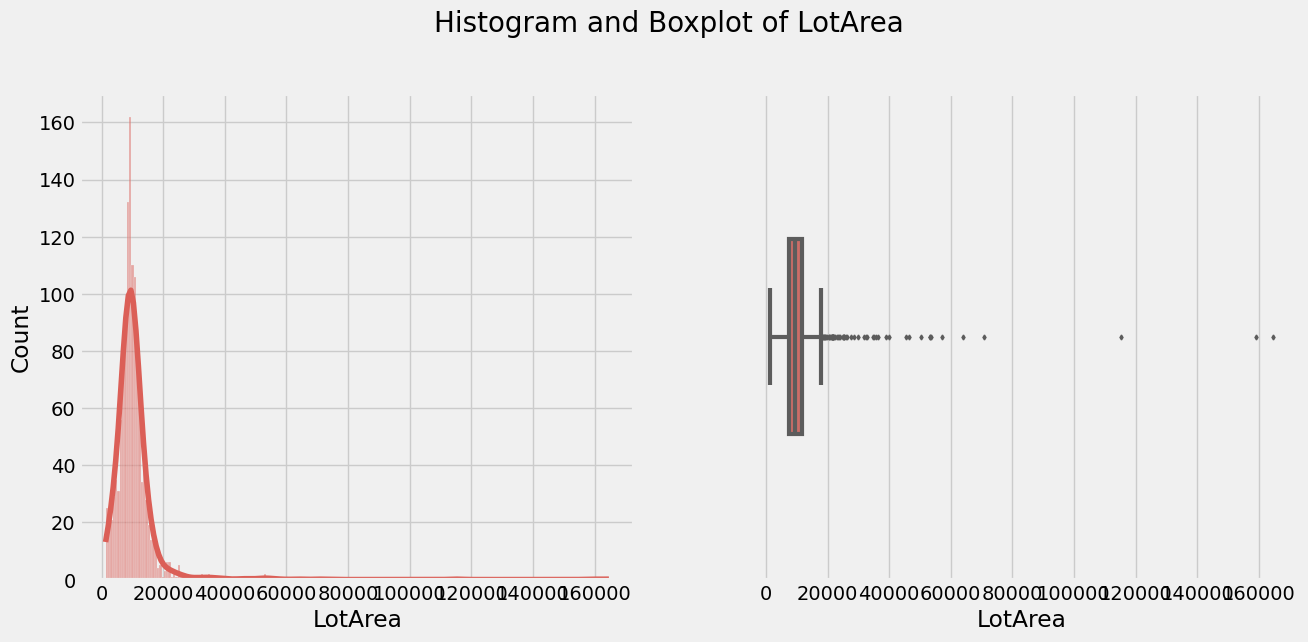

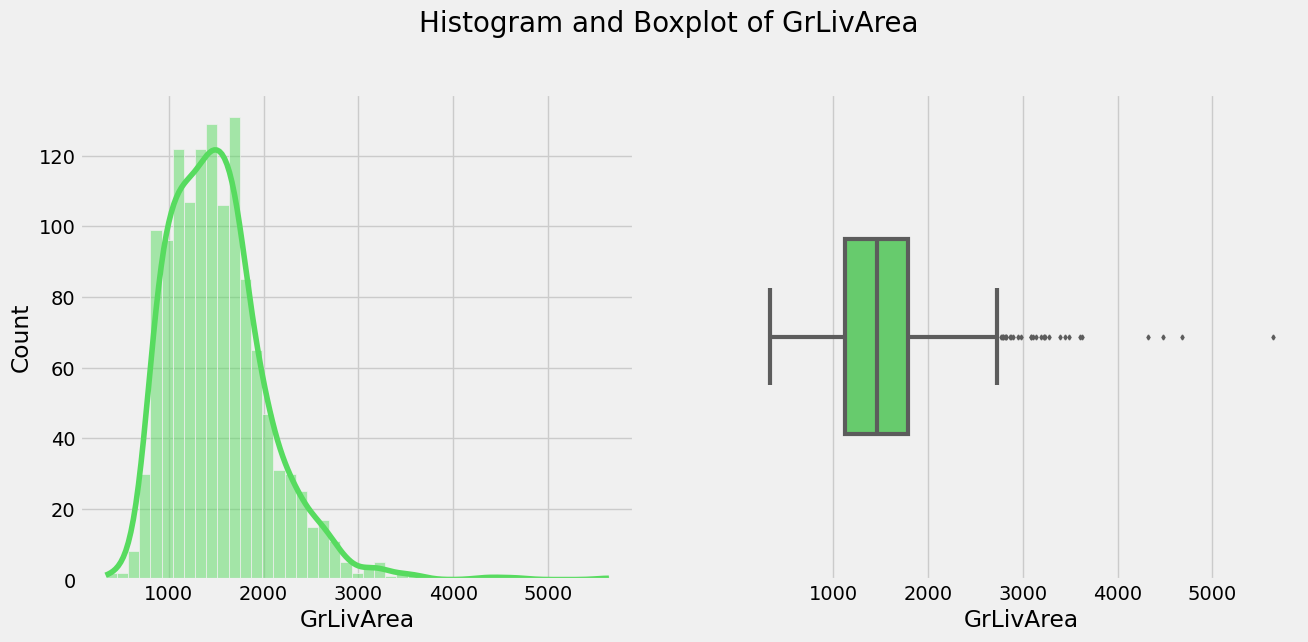

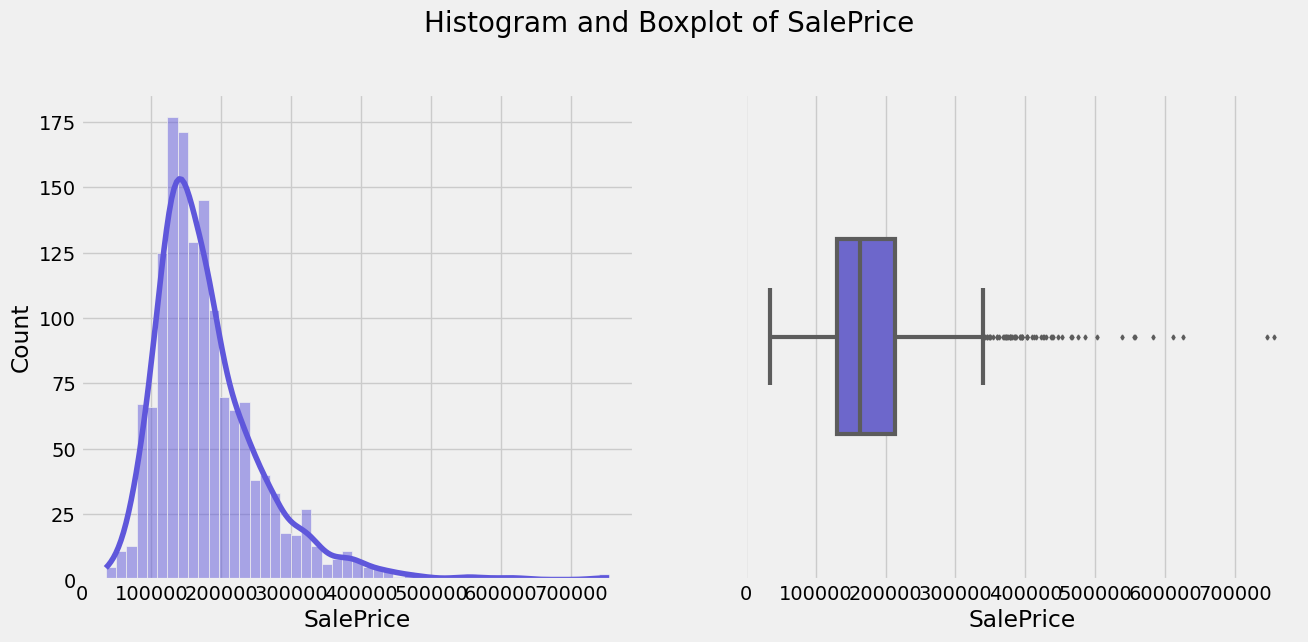

----------------------------------------------------------------------------------------------------
Countplot(s):



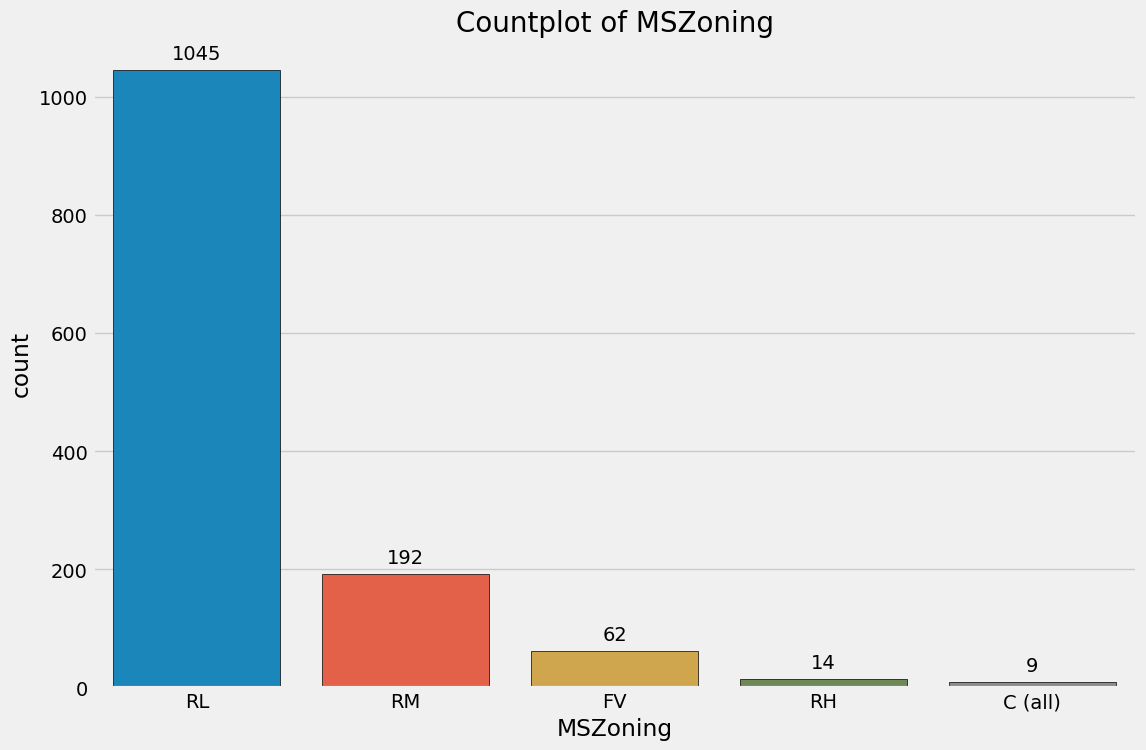

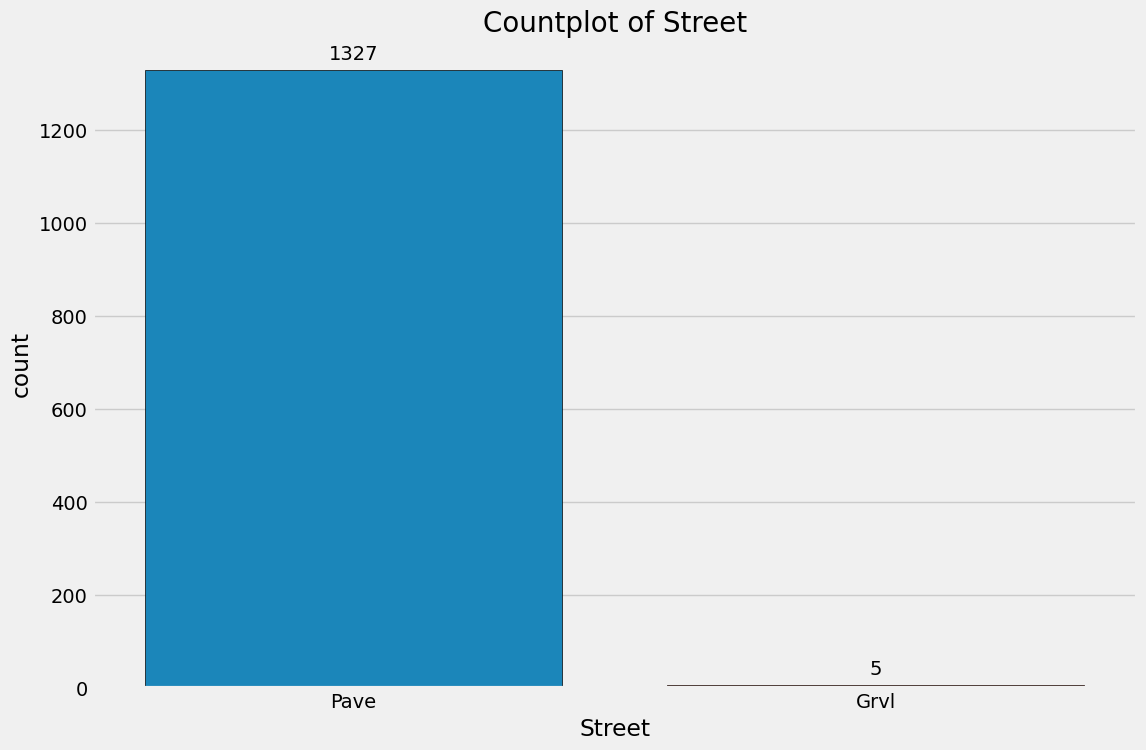

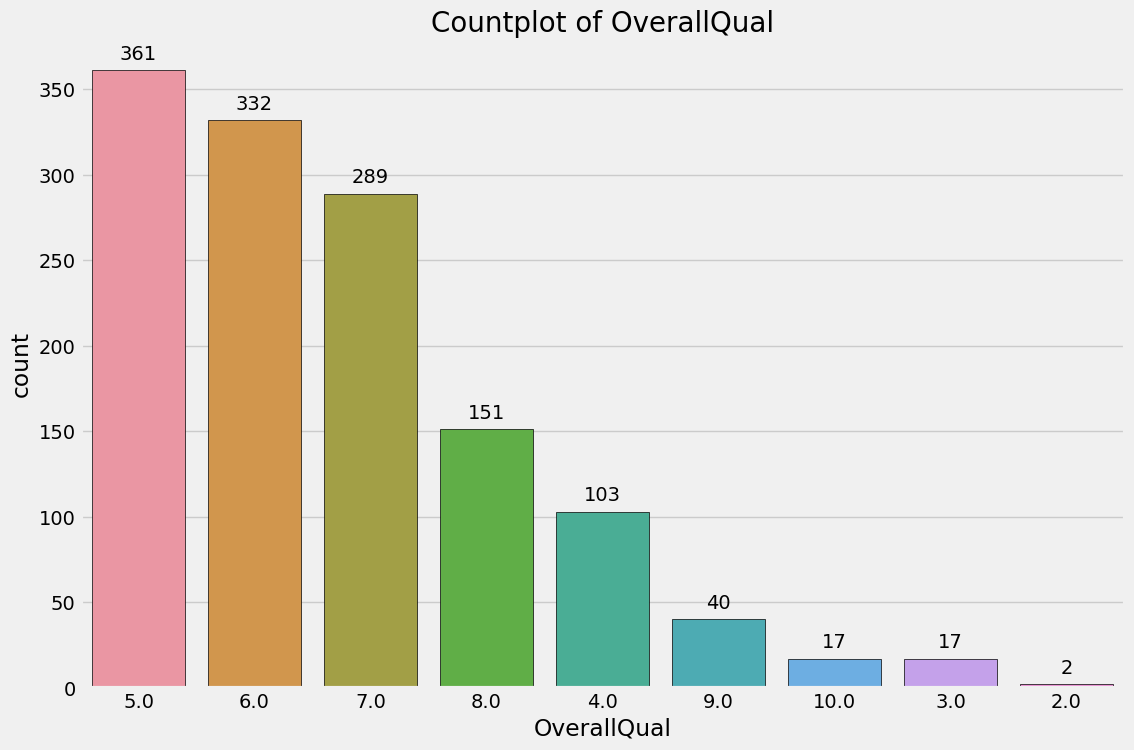

In [34]:
from fasteda import fast_eda
fast_eda(df)